In [1]:
import numpy as np
import pandas as pd
import pretty_midi
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import warnings
import os
import h5py

from IPython.core.debugger import set_trace

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import torch
import torch.nn as nn
from PIL import Image
from sklearn.metrics import accuracy_score
import os
import warnings
warnings.filterwarnings('ignore')
import cv2
from PIL import Image

from matplotlib.image import imread
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

Note: This first part is for extrapolating the data on your own from the million midi dataset, instructions for which can be found on this project's insipiration, https://github.com/sandershihacker/midi-classification-tutorial/blob/master/midi_classifier.ipynb. If you do not want to spend the hours pulling out the data and storing it on your machine, the files from the extracted information can be found with this project. Just make sure that the files are in the same folder as your Jupyter project.

Get the Genre and File Paths

In [2]:
def get_genres(path):
    """
    This function reads the genre labels and puts it into a pandas DataFrame.
    
    @input path: The path to the genre label file.
    @type path: String
    
    @return: A pandas dataframe containing the genres and midi IDs.
    @rtype: pandas.DataFrame
    """
    ids = []
    genres = []
    with open(path) as f:
        line = f.readline()
        while line:
            if line[0] != '#':
                [x, y, *_] = line.strip().split("\t")
                ids.append(x)
                genres.append(y)
            line = f.readline()
    genre_df = pd.DataFrame(data={"Genre": genres, "TrackID": ids})
    return genre_df

# Get the Genre DataFrame
genre_path = "msd_tagtraum_cd1.cls"
genre_df = get_genres(genre_path)

# Create Genre List and Dictionary
label_list = list(set(genre_df.Genre))
label_dict = {lbl: label_list.index(lbl) + 1 for lbl in label_list}

# Print to Visualize
print(genre_df.head(), end="\n\n")
print(label_list, end="\n\n")
print(label_dict, end="\n\n")

      Genre             TrackID
0  Pop_Rock  TRAAAAK128F9318786
1       Rap  TRAAAAW128F429D538
2  Pop_Rock  TRAAABD128F429CF47
3      Jazz  TRAAAED128E0783FAB
4  Pop_Rock  TRAAAEF128F4273421

['International', 'Folk', 'Pop_Rock', 'RnB', 'Blues', 'Jazz', 'Reggae', 'New Age', 'Electronic', 'Rap', 'Country', 'Vocal', 'Latin']

{'International': 1, 'Folk': 2, 'Pop_Rock': 3, 'RnB': 4, 'Blues': 5, 'Jazz': 6, 'Reggae': 7, 'New Age': 8, 'Electronic': 9, 'Rap': 10, 'Country': 11, 'Vocal': 12, 'Latin': 13}



Match the Midi to the Genre

In [3]:
def get_matched_midi(midi_folder, genre_df):
    """
    This function loads in midi file paths that are found in the given folder, puts this data into a
    pandas DataFrame, then matches each entry with a genre described in get_genres.
    
    @input midi_folder: The path to the midi files.
    @type midi_folder: String
    @input genre_df: The genre label dataframe generated by get_genres.
    @type genre_df: pandas.DataFrame
    
    @return: A dataframe of track id and path to a midi file with that track id.
    @rtype: pandas.DataFrame
    """
    # Get All Midi Files
    track_ids, file_paths = [], []
    #print(midi_folder)
    for dir_name, subdir_list, file_list in os.walk(midi_folder):
        if len(dir_name) == 36:
            track_id = dir_name[18:]
            file_path_list = ["/".join([dir_name, file]) for file in file_list]
            for file_path in file_path_list:
                track_ids.append(track_id)
                file_paths.append(file_path)
    all_midi_df = pd.DataFrame({"TrackID": track_ids, "Path": file_paths})
    
    # Inner Join with Genre Dataframe
    df = pd.merge(all_midi_df, genre_df, on='TrackID', how='inner')
    return df.drop(["TrackID"], axis=1)

# Obtain DataFrame with Matched Genres to File Paths
midi_path = "lmd_matched"
matched_midi_df = get_matched_midi(midi_path, genre_df)

# Print to Check Correctness
print(matched_midi_df.head())

                                                Path     Genre
0  lmd_matched\A\A\A\TRAAAGR128F425B14B/1d9d16a9d...  Pop_Rock
1  lmd_matched\A\A\A\TRAAAGR128F425B14B/5dd29e99e...  Pop_Rock
2  lmd_matched\A\A\A\TRAAAGR128F425B14B/b97c529ab...  Pop_Rock
3  lmd_matched\A\A\A\TRAAAGR128F425B14B/dac3cdd0d...  Pop_Rock
4  lmd_matched\A\A\D\TRAADKW128E079503A/3797e9b9a...  Pop_Rock


For this project, we will need two datasets, the one for the standerd neural network and one that is based on the format of an image for the CNN.

With the CNN, for each song will have 4 18x18 datasets, or 324 notes in total. The 4 datasets each represent a feature for the notes of the first instrument, being note start, note end, note pitch, and note velocity. 

For the regular, it will be a normal 2D array, where each row represents a song. the values stored in the array are metadata values that more generalize the entire song. This dataset is similar to the orginal version, just with a few more features.

Only Notes File Creation:

In [4]:

import pretty_midi
import warnings

note_total = 324
i = 0
count = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

with open('midi_info_start.txt', 'w') as f_start, \
     open('midi_info_end.txt', 'w') as f_end, \
     open('midi_info_pitch.txt', 'w') as f_pitch, \
     open('midi_info_velocity.txt', 'w') as f_velocity:
    
    for index, row in matched_midi_df.iterrows():
        #print(row.Path)
        
        genre = label_dict[row.Genre]
        if genre is not None:
            count[genre] = count[genre] + 1
            if count[genre] > 500:
                continue
            
        try:
            # Test for Corrupted Midi Files
            with warnings.catch_warnings():
                warnings.simplefilter("error")
                file = pretty_midi.PrettyMIDI(row.Path)
                notecount = 0
                for i, instrument in enumerate(file.instruments):
                    if i >= 1:
                        break
                    for index, note in enumerate(instrument.notes):
                        if index >= note_total:
                            break;
                        if index != note_total - 1:
                            f_start.write(f"{note.start},")
                            f_end.write(f"{note.end},")
                            f_pitch.write(f"{note.pitch},")
                            f_velocity.write(f"{note.velocity},")
                        else:
                            f_start.write(f"{note.start},{label_dict[row.Genre]}\n")
                            f_end.write(f"{note.end}\n")
                            f_pitch.write(f"{note.pitch}\n")
                            f_velocity.write(f"{note.velocity}\n")
                        notecount += 1
                        
                    #checks for if song is less than 100 notes, will fill with zeros if so
                    while notecount < note_total:
                        if notecount != note_total - 1:
                            f_start.write(f"{0},")
                            f_end.write(f"{0},")
                            f_pitch.write(f"{0},")
                            f_velocity.write(f"{0},")
                        else:
                            f_start.write(f"{0},{label_dict[row.Genre]}\n")
                            f_end.write(f"{0}\n")
                            f_pitch.write(f"{0}\n")
                            f_velocity.write(f"{0}\n")
                        notecount += 1
        except:
            continue
        i += 1
print(count)

[0, 86, 64, 9866, 423, 32, 282, 70, 230, 783, 121, 1059, 41, 303]


No Notes File Creation:

In [5]:
#This form includes the features included in the orginal project, with song length and pitch classes included
i = 0
count = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]

with open('midi_info_small.txt', 'w') as output_file:
    for index, row in matched_midi_df.iterrows():
        #print(row.Path)
        
        genre = label_dict[row.Genre]
        if genre is not None:
            count[genre] = count[genre] + 1
            if count[genre] > 500:
                continue
            
        try:
            # Test for Corrupted Midi Files
            with warnings.catch_warnings():
                warnings.simplefilter("error")
                file = pretty_midi.PrettyMIDI(row.Path)

                tempo = file.estimate_tempo()
                num_sig_changes = len(file.time_signature_changes)
                resolution = file.resolution
                ts_changes = file.time_signature_changes
                ts_1 = 4
                ts_2 = 4
                if len(ts_changes) > 0:
                    ts_1 = ts_changes[0].numerator
                    ts_2 = ts_changes[0].denominator
                song_length = file.get_end_time()
                pitch_class = file.get_pitch_class_histogram()
                
                output_file.write(f'{tempo},{num_sig_changes},{resolution},{ts_1},{ts_2},{song_length},{pitch_class[0]},{pitch_class[1]},{pitch_class[2]},{pitch_class[3]},{pitch_class[4]},{pitch_class[5]},{pitch_class[6]},{pitch_class[7]},{pitch_class[8]},{pitch_class[9]},{pitch_class[10]},{pitch_class[11]},{label_dict[row.Genre]}\n')
        except:
            continue
        i = i + 1  
print(count)

[0, 86, 64, 9866, 423, 32, 282, 70, 230, 783, 121, 1059, 41, 303]


No Notes Standard NN Implementation:

In [6]:
with open('midi_info_small.txt', 'r') as file:
    lines = file.readlines()

    # Convert the lines to a NumPy array
    simple_features = np.loadtxt(lines, delimiter=',')
    print(simple_features)
    print(simple_features.shape)

[[2.24177919e+02 1.00000000e+00 1.92000000e+02 ... 8.12064965e-03
  5.68445476e-02 3.00000000e+00]
 [2.41150166e+02 2.00000000e+00 4.80000000e+02 ... 0.00000000e+00
  1.06518283e-01 3.00000000e+00]
 [2.57689352e+02 1.00000000e+00 4.80000000e+02 ... 0.00000000e+00
  4.00219298e-02 3.00000000e+00]
 ...
 [2.50908279e+02 0.00000000e+00 4.80000000e+02 ... 0.00000000e+00
  7.86409316e-02 1.30000000e+01]
 [1.70264635e+02 1.00000000e+00 4.80000000e+02 ... 2.33488993e-02
  4.66977985e-02 4.00000000e+00]
 [1.70264635e+02 1.00000000e+00 4.80000000e+02 ... 2.33488993e-02
  4.66977985e-02 4.00000000e+00]]
(2973, 19)


In [7]:
from sklearn.model_selection import train_test_split
num_columns = simple_features.shape[1] - 1
simple_features = np.random.permutation(simple_features)

X = simple_features[:, :num_columns]
y = simple_features[:, num_columns].astype(int)

scaler = MinMaxScaler()
    
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2378, 18)
X_test shape: (595, 18)
y_train shape: (2378,)
y_test shape: (595,)


In [35]:
def get_variable_name(variable):
    for name, value in globals().items():
        if value is variable:
            return name
    return None

def train_and_test(clf):
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    
    clf_name = get_variable_name(clf)
    print(f"Accuracy of the NN {clf_name}: {accuracy}\n")

def train_model(t_features, t_labels, v_features, v_labels):
    #This function trains a neural network using a couple different configurations.
    
    # Neural Network Configurations
    clf_1 = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(5,), random_state=1)
    clf_2 = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(5, 5), random_state=1)
    clf_3 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 10), random_state=1)
    
    
    train_and_test(clf_1)
    train_and_test(clf_2)
    train_and_test(clf_3)
    
#classifier = train_model(training_features, training_labels, validation_features, validation_labels)
classifier = train_model(X_train, y_train, X_test, y_test)

Accuracy of the NN None: 0.2218487394957983

Accuracy of the NN None: 0.22521008403361345

Accuracy of the NN None: 0.2823529411764706



CNN With Four Dimensions

In [38]:
def parser(file_name):
    with open(file_name, 'r') as file:
        lines = file.readlines()

     # Convert the lines to a NumPy array
    labeled_features = np.loadtxt(lines, delimiter=',')
    return labeled_features

features_start = parser("midi_info_start.txt")
features_end = parser("midi_info_end.txt")
features_pitch = parser("midi_info_pitch.txt")
features_velocity = parser("midi_info_velocity.txt")

num_columns = features_start.shape[1] - 1

genre_labels = features_start[:, num_columns]
genre_labels = np.reshape(genre_labels, (len(genre_labels), 1))

features_start = features_start[:, :num_columns]

features_time = features_end - features_start
#features_start = np.delete(features_start, num_columns, axis=1)

print("Start Features Array:\n", features_start,"\n")
print("Start Features Shape:", features_start.shape,"\n")

print("End Features Array:\n", features_end,"\n")
print("End Features Shape:", features_end.shape,"\n")

print("Pitch Features Array:\n", features_pitch,"\n")
print("Pitch Features Shape:", features_pitch.shape,"\n")

print("Velocity Features Array:\n", features_velocity,"\n")
print("Velocity Features Shape:", features_velocity.shape,"\n")

print("time Features Array:\n", features_time,"\n")
print("time Features Shape:", features_time.shape,"\n")

print("Genre Labels:\n", genre_labels,"\n")
print("Genre Labels Shape:", genre_labels.shape,"\n")

Start Features Array:
 [[1.82291667e-02 2.55208333e-01 5.05208333e-01 ... 1.12255208e+02
  1.12505208e+02 1.12731771e+02]
 [1.98346800e+00 1.98346800e+00 1.98346800e+00 ... 2.10743475e+01
  2.11983142e+01 2.13222810e+01]
 [1.96718400e+00 2.21308200e+00 2.33603100e+00 ... 7.57365840e+01
  7.59824820e+01 7.61054310e+01]
 ...
 [2.00000000e+00 3.74791667e+00 7.74895833e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.06896500e+00 2.11948617e+02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.06896500e+00 2.11948617e+02 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]] 

Start Features Shape: (2973, 324) 

End Features Array:
 [[1.84895833e-01 4.37500000e-01 6.87500000e-01 ... 1.12437500e+02
  1.12687500e+02 1.12869792e+02]
 [2.06301333e+00 2.06301333e+00 2.07231084e+00 ... 2.11084384e+01
  2.12324051e+01 2.13563719e+01]
 [2.02968307e+00 2.26226160e+00 2.39033347e+00 ... 7.57990831e+01
  7.60316616e+01 7.61597335e+01]
 ...
 [4.00312500e+00

In [39]:
# Get the number of rows in the arrays
num_rows = features_start.shape[0]

# Shuffle indices
indices = np.random.permutation(num_rows)

# Use shuffled indices to reorder both arrays
features_start = features_start[indices]
features_time = features_time[indices]
features_end = features_end[indices]
features_pitch = features_pitch[indices]
features_velocity = features_velocity[indices]
genre_labels = genre_labels[indices]

In [40]:
# Create Scalar from SKLearn library
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform data
features_start = scaler.fit_transform(features_start)
features_end = scaler.fit_transform(features_end)
features_pitch = scaler.fit_transform(features_pitch)
features_velocity = scaler.fit_transform(features_velocity)
features_time = scaler.fit_transform(features_velocity)

#print("Start Features Array:\n", features_start,"\n")
print("Start Features Shape:", features_start.shape,"\n")

#print("End Features Array:\n", features_end,"\n")
print("End Features Shape:", features_end.shape,"\n")

#print("Pitch Features Array:\n", features_pitch,"\n")
print("Pitch Features Shape:", features_pitch.shape,"\n")

#print("Velocity Features Array:\n", features_velocity,"\n")
print("Velocity Features Shape:", features_velocity.shape,"\n")

Start Features Shape: (2973, 324) 

End Features Shape: (2973, 324) 

Pitch Features Shape: (2973, 324) 

Velocity Features Shape: (2973, 324) 



In [41]:
# Fit all data together into multidimensional array
train_dataset = np.stack((features_start, features_end, features_pitch, features_velocity), axis=2)

num_rows = features_start.shape[0]
train_dataset = train_dataset.reshape((num_rows, 18, 18, 4))

# Split data into training and testing data
num = len(train_dataset)
#num_training = int(num * 0.6)
#num_validation = int(num * 0.8)
num_training = int(num * 0.8)
num_validation = int(num)

train_set_x = train_dataset[:num_training]
train_set_y = genre_labels[:num_training]
test_set_x = train_dataset[num_training:num_validation]
test_set_y = genre_labels[num_training:num_validation]

# Shape to properly fit CNN model
train_set_x = np.transpose(train_set_x, (0,3,1,2))
test_set_x = np.transpose(test_set_x, (0,3,1,2))

#print("train_set_x:\n", train_set_x,"\n")
print("train_set_x:", train_set_x.shape,"\n")

#print("train_set_y:\n", train_set_y,"\n")
print("train_set_y:", train_set_y.shape,"\n")

#print("test_set_x:\n", test_set_x,"\n")
print("test_set_x:", test_set_x.shape,"\n")

#print("test_set_y:\n", test_set_y,"\n")
print("test_set_y:", test_set_y.shape,"\n")

train_set_x: (2378, 4, 18, 18) 

train_set_y: (2378, 1) 

test_set_x: (595, 4, 18, 18) 

test_set_y: (595, 1) 



In [42]:
# Change to tensors
train_set_x = torch.tensor(train_set_x, dtype=torch.float32)#.unsqueeze(dim=0)
test_set_x = torch.tensor(test_set_x, dtype=torch.float32)#.unsqueeze(dim=0)
train_set_y = torch.tensor(train_set_y, dtype=torch.float32)
test_set_y = torch.tensor(test_set_y, dtype=torch.float32)

print("Training shape: ", train_set_x.shape, train_set_y.shape)
print("Testing shape:  ", test_set_x.shape, test_set_y.shape)

Training shape:  torch.Size([2378, 4, 18, 18]) torch.Size([2378, 1])
Testing shape:   torch.Size([595, 4, 18, 18]) torch.Size([595, 1])


In [43]:
# 4D Convolutional neural network (two convolutional layers)
class CNN4D(nn.Module):
    def __init__(self):
        super(CNN4D, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size = 3, stride = 1, padding = 1), #changes depending on image or other
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc1 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU())
        self.fc2 = nn.Linear(128, 14)
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)

        return out
    
#-------------------------------------------------------------------------- 
  
#3D Convolutional neural network (two convolutional layers)
class CNNGray(nn.Module):
    def __init__(self):
        super(CNNGray, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, stride = 1, padding = 1), #changes depending on image or other
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc1 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU())
        self.fc2 = nn.Linear(128, 14)
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)

        return out

In [44]:
model = CNN4D()
print (model)

CNN4D(
  (layer1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=128, out_features=14, bias=True)
)


In [45]:
train_set_y = train_set_y.squeeze(dim=1).long()
print("train_set_y:", train_set_y.shape)

train_set_y: torch.Size([2378])


In [46]:
# Create model instance
model = CNN4D()

#set up objects needed for training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 2000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_set_x)
    loss = criterion(outputs, train_set_y.long())
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 99:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/2000], Loss: 2.2187
Epoch [200/2000], Loss: 2.1808
Epoch [300/2000], Loss: 2.1505
Epoch [400/2000], Loss: 2.1213
Epoch [500/2000], Loss: 2.0909
Epoch [600/2000], Loss: 2.0569
Epoch [700/2000], Loss: 2.0187
Epoch [800/2000], Loss: 1.9760
Epoch [900/2000], Loss: 1.9276
Epoch [1000/2000], Loss: 1.8739
Epoch [1100/2000], Loss: 1.8152
Epoch [1200/2000], Loss: 1.7512
Epoch [1300/2000], Loss: 1.6831
Epoch [1400/2000], Loss: 1.6198
Epoch [1500/2000], Loss: 1.5428
Epoch [1600/2000], Loss: 1.4916
Epoch [1700/2000], Loss: 1.4069
Epoch [1800/2000], Loss: 1.3421
Epoch [1900/2000], Loss: 1.2848
Epoch [2000/2000], Loss: 1.2161


In [47]:
with torch.no_grad():
    model.eval()
    outputs = model(test_set_x)
    _, y_pred = torch.max(outputs, 1)
    accuracy = accuracy_score(test_set_y.numpy(), y_pred.numpy())
    print("Accuracy:", accuracy)

Accuracy: 0.33613445378151263


In [48]:
del model
del train_dataset
del train_set_x
del train_set_y
del test_set_x
del test_set_y

3D CNN Implementation With Zero Crossing  

In [49]:
# Fit all data together into multidimensional array
train_dataset = np.stack((features_time, features_pitch, features_velocity), axis=2)

num_rows = features_start.shape[0]
train_dataset = train_dataset.reshape((num_rows, 18, 18, 3))

In [50]:
image = train_dataset[1]

In [51]:
#Define Laplacian Filter
def gray(rgb):
    return rgb[...,:3] @ [0.2989, 0.5870, 0.1140]

def laplacian_filter(image):
    laplacian_kernel = np.array([[0, 1, 0],
                                 [1, -4, 1],
                                 [0, 1, 0]])
    return convolve(image, laplacian_kernel)

#Define Zero Crossings function
def zero_crossings(image):
    z_image = np.zeros_like(image)
    for x in range(1, image.shape[0]-1):
        for y in range(1, image.shape[1]-1):
            neighbors = [image[x-1, y], 
                         image[x+1, y], 
                         image[x, y-1], 
                         image[x, y+1]]
            if image[x, y] == 0 and any(n < 0 for n in neighbors) and any(n > 0 for n in neighbors):
                z_image[x, y] = 1
            elif np.sign(image[x, y]) != np.sign(sum(neighbors) / 4):
                z_image[x, y] = 1
    return z_image

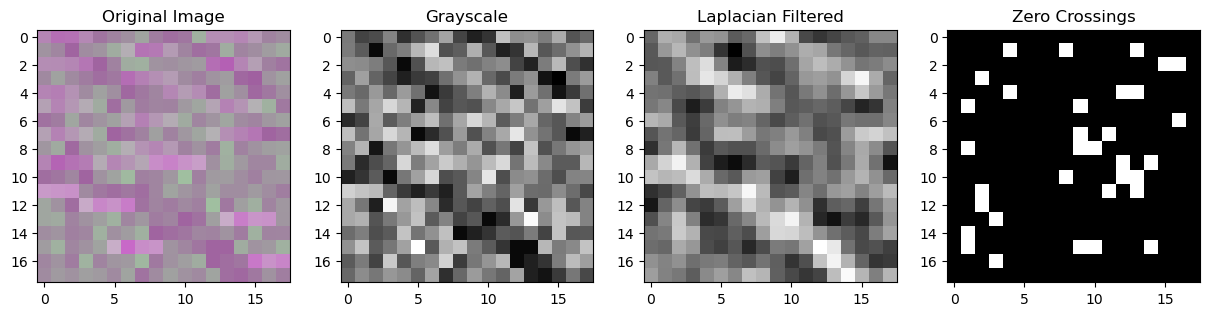

In [52]:
gray_image = gray(image)
blur_image = gaussian_filter(gray_image, sigma=1)
laplacian_image = laplacian_filter(blur_image)
edges = zero_crossings(laplacian_image)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale')
plt.subplot(1, 4, 3)
plt.imshow(laplacian_image, cmap='gray')
plt.title('Laplacian Filtered')
plt.subplot(1, 4, 4)
plt.imshow(edges, cmap='gray')
plt.title('Zero Crossings')
plt.show()

In [53]:
train_dataset3D = []
for image in train_dataset:
    #R, G, B = image[:,:,0], image[:,:,1],  image[:,:,2]
    gray_image = gray(image)
    blur_image = gaussian_filter(gray_image, sigma=1)
    laplacian_image = laplacian_filter(blur_image)
    edges = zero_crossings(laplacian_image)
    train_dataset3D.append(edges)

    # Convert the list of images to a numpy array
train_dataset3D = np.array(train_dataset3D)

print("Overall shape: ", train_dataset3D.shape)

Overall shape:  (2973, 18, 18)


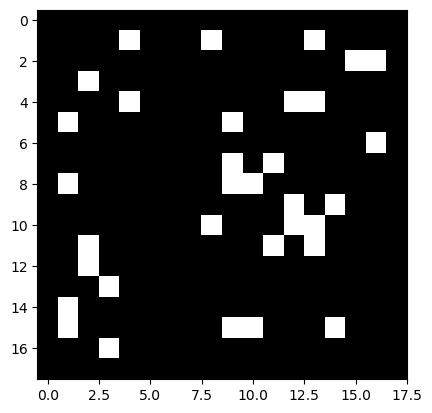

In [54]:
plt.imshow(train_dataset3D[1], cmap = "gray")

In [55]:
# Split data into training and testing data
num = len(train_dataset)
num_training = int(num * 0.8)
num_validation = int(num)

zc_train_set_x = train_dataset3D[:num_training]
zc_train_set_y = genre_labels[:num_training]
zc_test_set_x = train_dataset3D[num_training:num_validation]
zc_test_set_y = genre_labels[num_training:num_validation]

#print("train_set_x:\n", train_set_x,"\n")
print("train_set_x:", zc_train_set_x.shape,"\n")

#print("train_set_y:\n", train_set_y,"\n")
print("train_set_y:", zc_train_set_y.shape,"\n")

#print("test_set_x:\n", test_set_x,"\n")
print("test_set_x:", zc_test_set_x.shape,"\n")

#print("test_set_y:\n", test_set_y,"\n")
print("test_set_y:", zc_test_set_y.shape,"\n")

train_set_x: (2378, 18, 18) 

train_set_y: (2378, 1) 

test_set_x: (595, 18, 18) 

test_set_y: (595, 1) 



In [56]:
# Change to tensors
zc_train_set_x = torch.tensor(zc_train_set_x, dtype=torch.float32).unsqueeze(dim=0)
zc_test_set_x = torch.tensor(zc_test_set_x, dtype=torch.float32).unsqueeze(dim=0)
zc_train_set_y = torch.tensor(zc_train_set_y, dtype=torch.float32)
zc_test_set_y = torch.tensor(zc_test_set_y, dtype=torch.float32)

print("Training shape: ", zc_train_set_x.shape, zc_train_set_y.shape)
print("Testing shape:  ", zc_test_set_x.shape, zc_test_set_y.shape)

Training shape:  torch.Size([1, 2378, 18, 18]) torch.Size([2378, 1])
Testing shape:   torch.Size([1, 595, 18, 18]) torch.Size([595, 1])


In [57]:
zc_train_set_x = np.transpose(zc_train_set_x, (1,0,2,3))
zc_test_set_x = np.transpose(zc_test_set_x, (1,0,2,3))

print("Training shape: ", zc_train_set_x.shape)
print("Testing shape:  ", zc_test_set_x.shape)

Training shape:  torch.Size([2378, 1, 18, 18])
Testing shape:   torch.Size([595, 1, 18, 18])


In [58]:
zc_train_set_y = zc_train_set_y.squeeze(dim=1).long()
print("train_set_y:", zc_train_set_y.shape)

train_set_y: torch.Size([2378])


In [59]:
model2 = CNNGray()
print (model2)

CNNGray(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=128, out_features=14, bias=True)
)


In [60]:
# Create model instance
model2 = CNNGray()

#set up objects needed for training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)

# Train the model
num_epochs = 2000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model2(zc_train_set_x)
    loss = criterion(outputs, zc_train_set_y.long())
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 99:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/2000], Loss: 2.2085
Epoch [200/2000], Loss: 2.1559
Epoch [300/2000], Loss: 2.1058
Epoch [400/2000], Loss: 2.0524
Epoch [500/2000], Loss: 1.9938
Epoch [600/2000], Loss: 1.9290
Epoch [700/2000], Loss: 1.8562
Epoch [800/2000], Loss: 1.7755
Epoch [900/2000], Loss: 1.6883
Epoch [1000/2000], Loss: 1.5958
Epoch [1100/2000], Loss: 1.4988
Epoch [1200/2000], Loss: 1.3998
Epoch [1300/2000], Loss: 1.3008
Epoch [1400/2000], Loss: 1.2033
Epoch [1500/2000], Loss: 1.1189
Epoch [1600/2000], Loss: 1.0440
Epoch [1700/2000], Loss: 0.9629
Epoch [1800/2000], Loss: 0.8797
Epoch [1900/2000], Loss: 0.8012
Epoch [2000/2000], Loss: 0.7370


In [61]:
with torch.no_grad():
        model2.eval()
        outputs = model2(zc_test_set_x)
        _, y_pred = torch.max(outputs, 1)
        accuracy = accuracy_score(zc_test_set_y.numpy(), y_pred.numpy())
        print("Accuracy:", accuracy)

Accuracy: 0.3596638655462185


In [ ]:
del features_velocity
del features_pitch
del features_start
del features_end
del features_time